In [1]:
from ukis_pysat.raster import Image
from pathlib import Path
import io
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio as rio
import torch
from tqdm import tqdm
from torch import optim
from src.logger.logger import create_logger
from src.dataset.dataset import get_dataloader
from src.models.unet import UNet
from src.models.unet_plus import UNetPlusPlus
from src.dataset.dataset import SegDataset
from src.models.concrete_dropout import UNet as UNetConcrete

from src.train import (
    criterion,
    get_metrics,
    get_device,
    set_seed,
    configure_deterministic_behavior,
)

BASE_DIR = Path("/eodc/private/tuwgeo/users/mabdelaa")
DATA_DIR = BASE_DIR / "repos/s1s2_water/data"
S2_M_Path = BASE_DIR / "repos/seg_likelihood/models/concrete_v2/s2_zscore_256_slope_UNet_concrete.pth"
S1_M_Path = BASE_DIR / "repos/seg_likelihood/models/s1_zscore_256_slope_UNetConcrete_concrete_v2.pth"


/home/fs70533/mabdelaa/.local/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.1'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def z_score_norm(input_array, sensor, data_dir):
    mean = np.load(data_dir / f"{sensor}_mean.npy")
    std = np.load(data_dir / f"{sensor}_std.npy")
    return (input_array - mean) / std


def load_image(image_path):
    with rio.open(image_path) as src:
        return src.read(), src.meta

def random_window(width, height, max_width, max_height):
    x = random.randint(0, max_width - width)
    y = random.randint(0, max_height - height)
    return Window(x, y, width, height)


def sliding_windows(width, height, window_width, window_height):
    for row_off in range(0, height, window_height):
        for col_off in range(0, width, window_width):
            # Ensure the window does not exceed the image bounds
            w = min(window_width, width - col_off)
            h = min(window_height, height - row_off)
            yield rio.windows.Window(col_off=col_off, row_off=row_off, width=w, height=h)

def reproject_to_match(source_path, target_crs, target_transform, target_width, target_height):
    with rio.open(source_path) as src:
        dst_array = np.empty((src.count, target_height, target_width), dtype=src.dtypes[0])
        reproject(
            source=rio.band(src, list(range(1, src.count + 1))),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )
        return dst_array, src.dtypes[0], src.count

def subset_array(array, window):
    return array[:, window.row_off:window.row_off + window.height,
                    window.col_off:window.col_off + window.width]

def load_random_subset(num: int, window_size=(3500, 3500)):
    BASE_DIR = Path("/eodc/private/tuwgeo/users/mabdelaa")
    s2_path = BASE_DIR / f"repos/s1s2_water/data/{num}/sentinel12_s2_{num}_img.tif"
    s1_path = BASE_DIR / f"repos/s1s2_water/data/{num}/sentinel12_s1_{num}_img.tif"
    mask_path = BASE_DIR / f"repos/s1s2_water/data/{num}/sentinel12_s2_{num}_msk.tif"
    slope_path = BASE_DIR / f"repos/s1s2_water/data/{num}/sentinel12_copdem30_{num}_slope.tif"

    # Read S2 as reference
    with rio.open(s2_path) as s2_src:
        s2_meta = s2_src.meta
        s2_crs = s2_meta['crs']
        s2_transform = s2_src.transform
        s2_width = s2_meta['width']
        s2_height = s2_meta['height']
        s2_array = s2_src.read()

    # Reproject others to match S2
    s1_reproj, s1_dtype, s1_count = reproject_to_match(s1_path, s2_crs, s2_transform, s2_width, s2_height)
    mask_reproj, mask_dtype, mask_count = reproject_to_match(mask_path, s2_crs, s2_transform, s2_width, s2_height)
    slope_reproj, slope_dtype, slope_count = reproject_to_match(slope_path, s2_crs, s2_transform, s2_width, s2_height)

    # Generate same window
    window = random_window(window_size[0], window_size[1], s2_width, s2_height)

    # Subset arrays

    s2_array = np.transpose(s2_array, (1,2,0))
    s2_array = s2_array[:,:,[0,1,2,3]]
    s1_reproj = np.transpose(s1_reproj, (1,2,0))
    s2_array =  z_score_norm(s2_array , "s2", DATA_DIR)
    s1_reproj = z_score_norm(s1_reproj, "s1", DATA_DIR)
    s2_array = np.transpose(s2_array, (2,0,1))
    s1_reproj = np.transpose(s1_reproj, (2,0,1))
    s2_subset = subset_array(s2_array, window)
    s1_subset = subset_array(s1_reproj, window)
    mask_subset = subset_array(mask_reproj, window)
    slope_subset = subset_array(slope_reproj, window)

    # Shared subset profile
    base_profile = s2_meta.copy()
    base_profile.update({
        'height': window.height,
        'width': window.width,
        'transform': rio.windows.transform(window, s2_transform)
    })

    # Update individual profiles
    s2_profile = base_profile.copy()

    s1_profile = base_profile.copy()
    s1_profile.update({'dtype': s1_dtype, 'count': s1_count, 'crs': s2_crs})

    mask_profile = base_profile.copy()
    mask_profile.update({'dtype': mask_dtype, 'count': mask_count, 'crs': s2_crs})

    slope_profile = base_profile.copy()
    slope_profile.update({'dtype': slope_dtype, 'count': slope_count, 'crs': s2_crs})

    return (s1_subset, s2_subset, mask_subset, slope_subset), (s1_profile, s2_profile, mask_profile, slope_profile) , window


def load_all_data_once(num: int):
    BASE_DIR = Path("/eodc/private/tuwgeo/users/mabdelaa")
    s2_path = BASE_DIR / f"repos/s1s2_water/data/{num}/sentinel12_s2_{num}_img.tif"
    s1_path = BASE_DIR / f"repos/s1s2_water/data/{num}/sentinel12_s1_{num}_img.tif"
    mask_path = BASE_DIR / f"repos/s1s2_water/data/{num}/sentinel12_s2_{num}_msk.tif"
    slope_path = BASE_DIR / f"repos/s1s2_water/data/{num}/sentinel12_copdem30_{num}_slope.tif"

    with rio.open(s2_path) as s2_src:
        s2_meta = s2_src.meta
        s2_crs = s2_meta['crs']
        s2_transform = s2_src.transform
        s2_width = s2_meta['width']
        s2_height = s2_meta['height']
        s2_array = s2_src.read()

    s1_reproj, s1_dtype, s1_count = reproject_to_match(s1_path, s2_crs, s2_transform, s2_width, s2_height)
    mask_reproj, mask_dtype, mask_count = reproject_to_match(mask_path, s2_crs, s2_transform, s2_width, s2_height)
    slope_reproj, slope_dtype, slope_count = reproject_to_match(slope_path, s2_crs, s2_transform, s2_width, s2_height)

    s2_array = np.transpose(s2_array, (1, 2, 0))[:, :, [0, 1, 2, 3]]
    s1_reproj = np.transpose(s1_reproj, (1, 2, 0))

    s2_array = s2_array/10000
    s2_array = z_score_norm(s2_array, "s2", DATA_DIR)

    s1_reproj  = s1_reproj/100
    s1_reproj = z_score_norm(s1_reproj, "s1", DATA_DIR)

    slope_reproj = slope_reproj/100
    s2_array = np.transpose(s2_array, (2, 0, 1))
    s1_reproj = np.transpose(s1_reproj, (2, 0, 1))

    base_profile = s2_meta.copy()
    base_profile.update({'crs': s2_crs})

    return {
        's2_array': s2_array,
        's1_array': s1_reproj,
        'mask_array': mask_reproj,
        'slope_array': slope_reproj,
        'transform': s2_transform,
        'width': s2_width,
        'height': s2_height,
        'base_profile': base_profile,
        'profiles_dtype_count': {
            's1': (s1_dtype, s1_count),
            'mask': (mask_dtype, mask_count),
            'slope': (slope_dtype, slope_count),
        }
    }


def get_random_subset_from_loaded(loaded_data, window_size=(2500, 2500)):
    #window = random_window(window_size[0], window_size[1], loaded_data['width'], loaded_data['height'])

    for window in sliding_windows(loaded_data['width'] ,loaded_data['height'], *window_size):
        
        s2_subset = subset_array(loaded_data['s2_array'], window)
        s1_subset = subset_array(loaded_data['s1_array'], window)
        mask_subset = subset_array(loaded_data['mask_array'], window)
        slope_subset = subset_array(loaded_data['slope_array'], window)
    
        base_profile = loaded_data['base_profile'].copy()
        base_profile.update({
            'height': window.height,
            'width': window.width,
            'transform': rio.windows.transform(window, loaded_data['transform'])
        })
    
        s1_dtype, s1_count = loaded_data['profiles_dtype_count']['s1']
        mask_dtype, mask_count = loaded_data['profiles_dtype_count']['mask']
        slope_dtype, slope_count = loaded_data['profiles_dtype_count']['slope']
    
        s2_profile = base_profile.copy()
    
        s1_profile = base_profile.copy()
        s1_profile.update({'dtype': s1_dtype, 'count': s1_count})
    
        mask_profile = base_profile.copy()
        mask_profile.update({'dtype': mask_dtype, 'count': mask_count})
    
        slope_profile = base_profile.copy()
        slope_profile.update({'dtype': slope_dtype, 'count': slope_count})
    
        yield (s1_subset, s2_subset, mask_subset, slope_subset), (s1_profile, s2_profile, mask_profile, slope_profile), window

In [3]:
def load_models(device):
    import warnings

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        with open(S2_M_Path, "rb") as f:
            s2_buffer = io.BytesIO(f.read())
            model = torch.load(s2_buffer)  
            s2_model = UNetConcrete(in_channels=5, out_channels=1).to(device)
            s2_model.load_state_dict(model)
    
        with open(S1_M_Path, "rb") as f:
            s1_buffer = io.BytesIO(f.read())
            model = torch.load(s1_buffer)  
            s1_model = UNetConcrete(in_channels=3, out_channels=1).to(device)
        s1_model.load_state_dict(model)

    return s2_model, s1_model 



def predict(s2_patch, s1_patch, num_forward=100):

    device = get_device()
    s2_model, s1_model = load_models(device)
    s2_model.eval()
    s1_model.eval()

    # Prepare input tensors
    s2_img = torch.from_numpy(s2_patch).permute(2, 0, 1).unsqueeze(0).to(device, dtype=torch.float32)
    s1_img = torch.from_numpy(s1_patch).permute(2, 0, 1).unsqueeze(0).to(device, dtype=torch.float32)

    # Perform multiple stochastic passes
    s2_preds, s1_preds = [], []
    with torch.no_grad():
        for _ in range(num_forward):
            s2_logits,_ = s2_model(s2_img)
            s1_logits,_ = s1_model(s1_img)
            s2_preds.append(s2_logits)
            s1_preds.append(s1_logits)

    # Stack all passes and compute statistics
    s2_stack = torch.stack(s2_preds, dim=0)  # [T, 1, H, W]
    s2_stack = torch.sigmoid(s2_stack)
    s1_stack = torch.stack(s1_preds, dim=0)
    s1_stack = torch.sigmoid(s1_stack)
    

    s2_mu = s2_stack.mean(dim=0)
    s1_mu = s1_stack.mean(dim=0)

    # Uncertainty = variance across forward passes
    s2_sigma = s2_stack.std(dim=0)
    s1_sigma = s1_stack.std(dim=0)

    # Deterministic thresholded masks
    s2_det = (s2_mu > 0.5).float()
    s1_det = (s1_mu > 0.5).float()

    # Convert to numpy
    to_numpy = lambda x: x.squeeze(0).squeeze(0).cpu().detach().numpy()
    predictions = [s2_det, s2_mu, s2_sigma, s1_det, s1_mu, s1_sigma]
    predictions = [to_numpy(pred) for pred in predictions]

    return predictions


def predictive_entropy_log2_reversed(mu, eps=1e-8):

    if isinstance(mu, np.ndarray):
        mu = torch.from_numpy(mu)
 
    # predictive entropy in log base 2
    H = -(mu * torch.log2(mu + eps) + (1 - mu) * torch.log2(1 - mu + eps))  # [B,1,H,W]
    
    # clamp to [0,1] because max entropy for binary with log2 is 1
    H_clamped = torch.clamp(H, 0.0, 1.0)
    
    # reverse scale so that high confidence = 1, low confidence = 0
    H_reversed = 1.0 - H_clamped
    return H_reversed



num = 89
loaded = load_all_data_once(num = num)



Window(col_off=0, row_off=0, width=2500, height=2500)


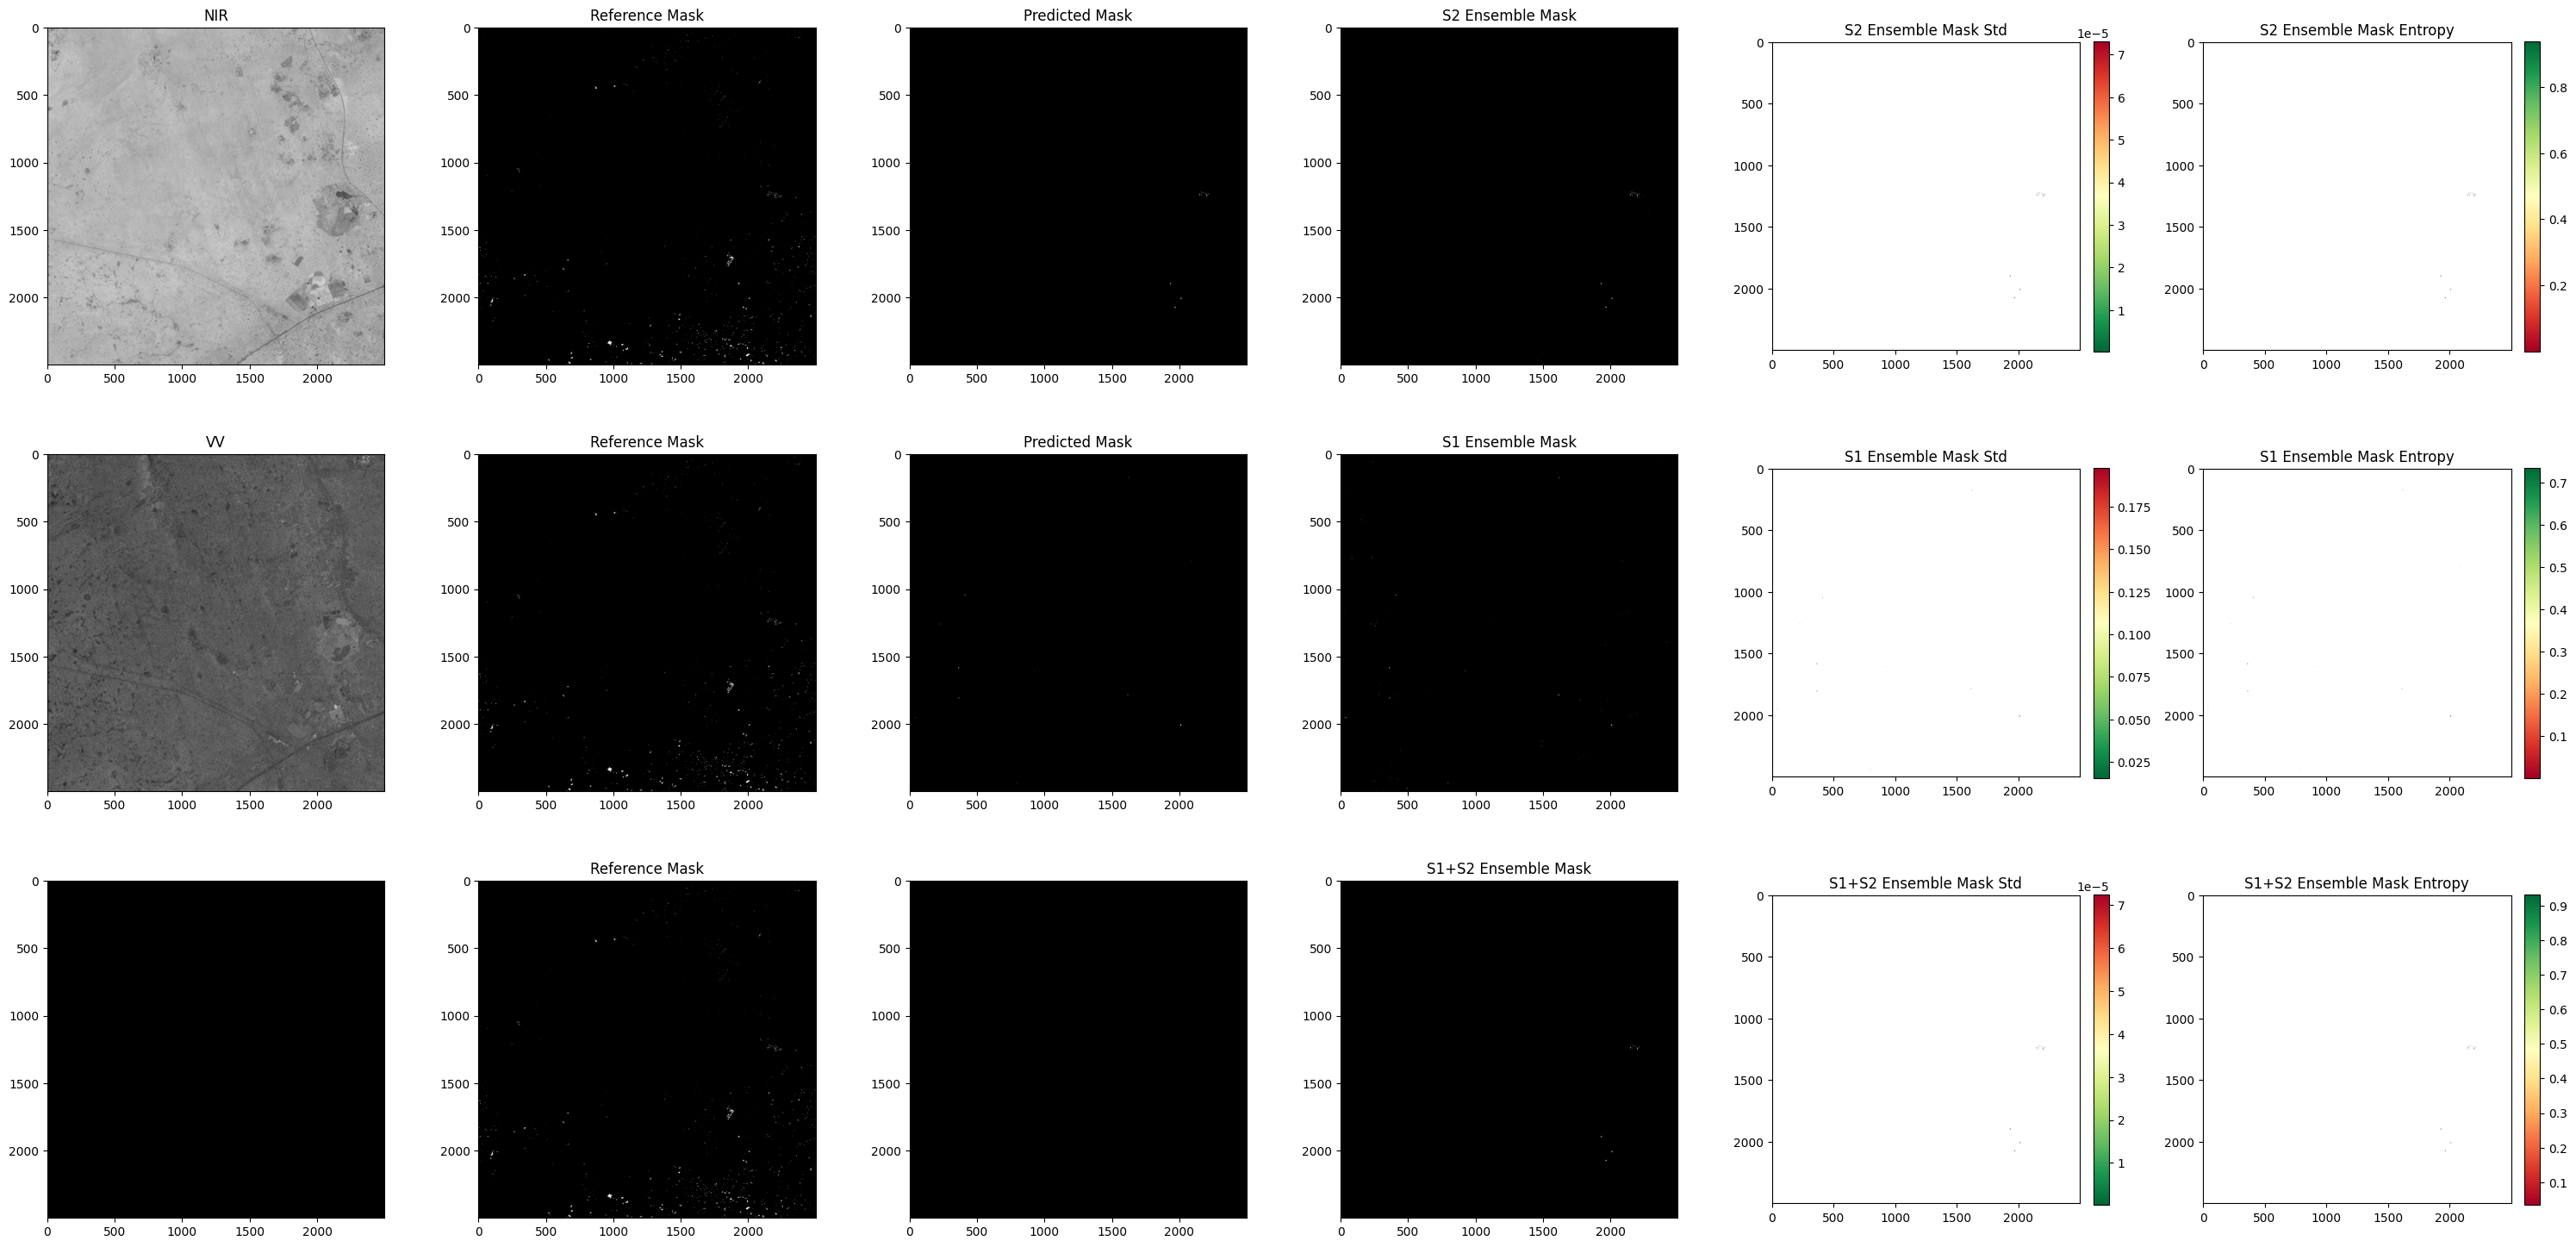

Window(col_off=2500, row_off=0, width=2500, height=2500)


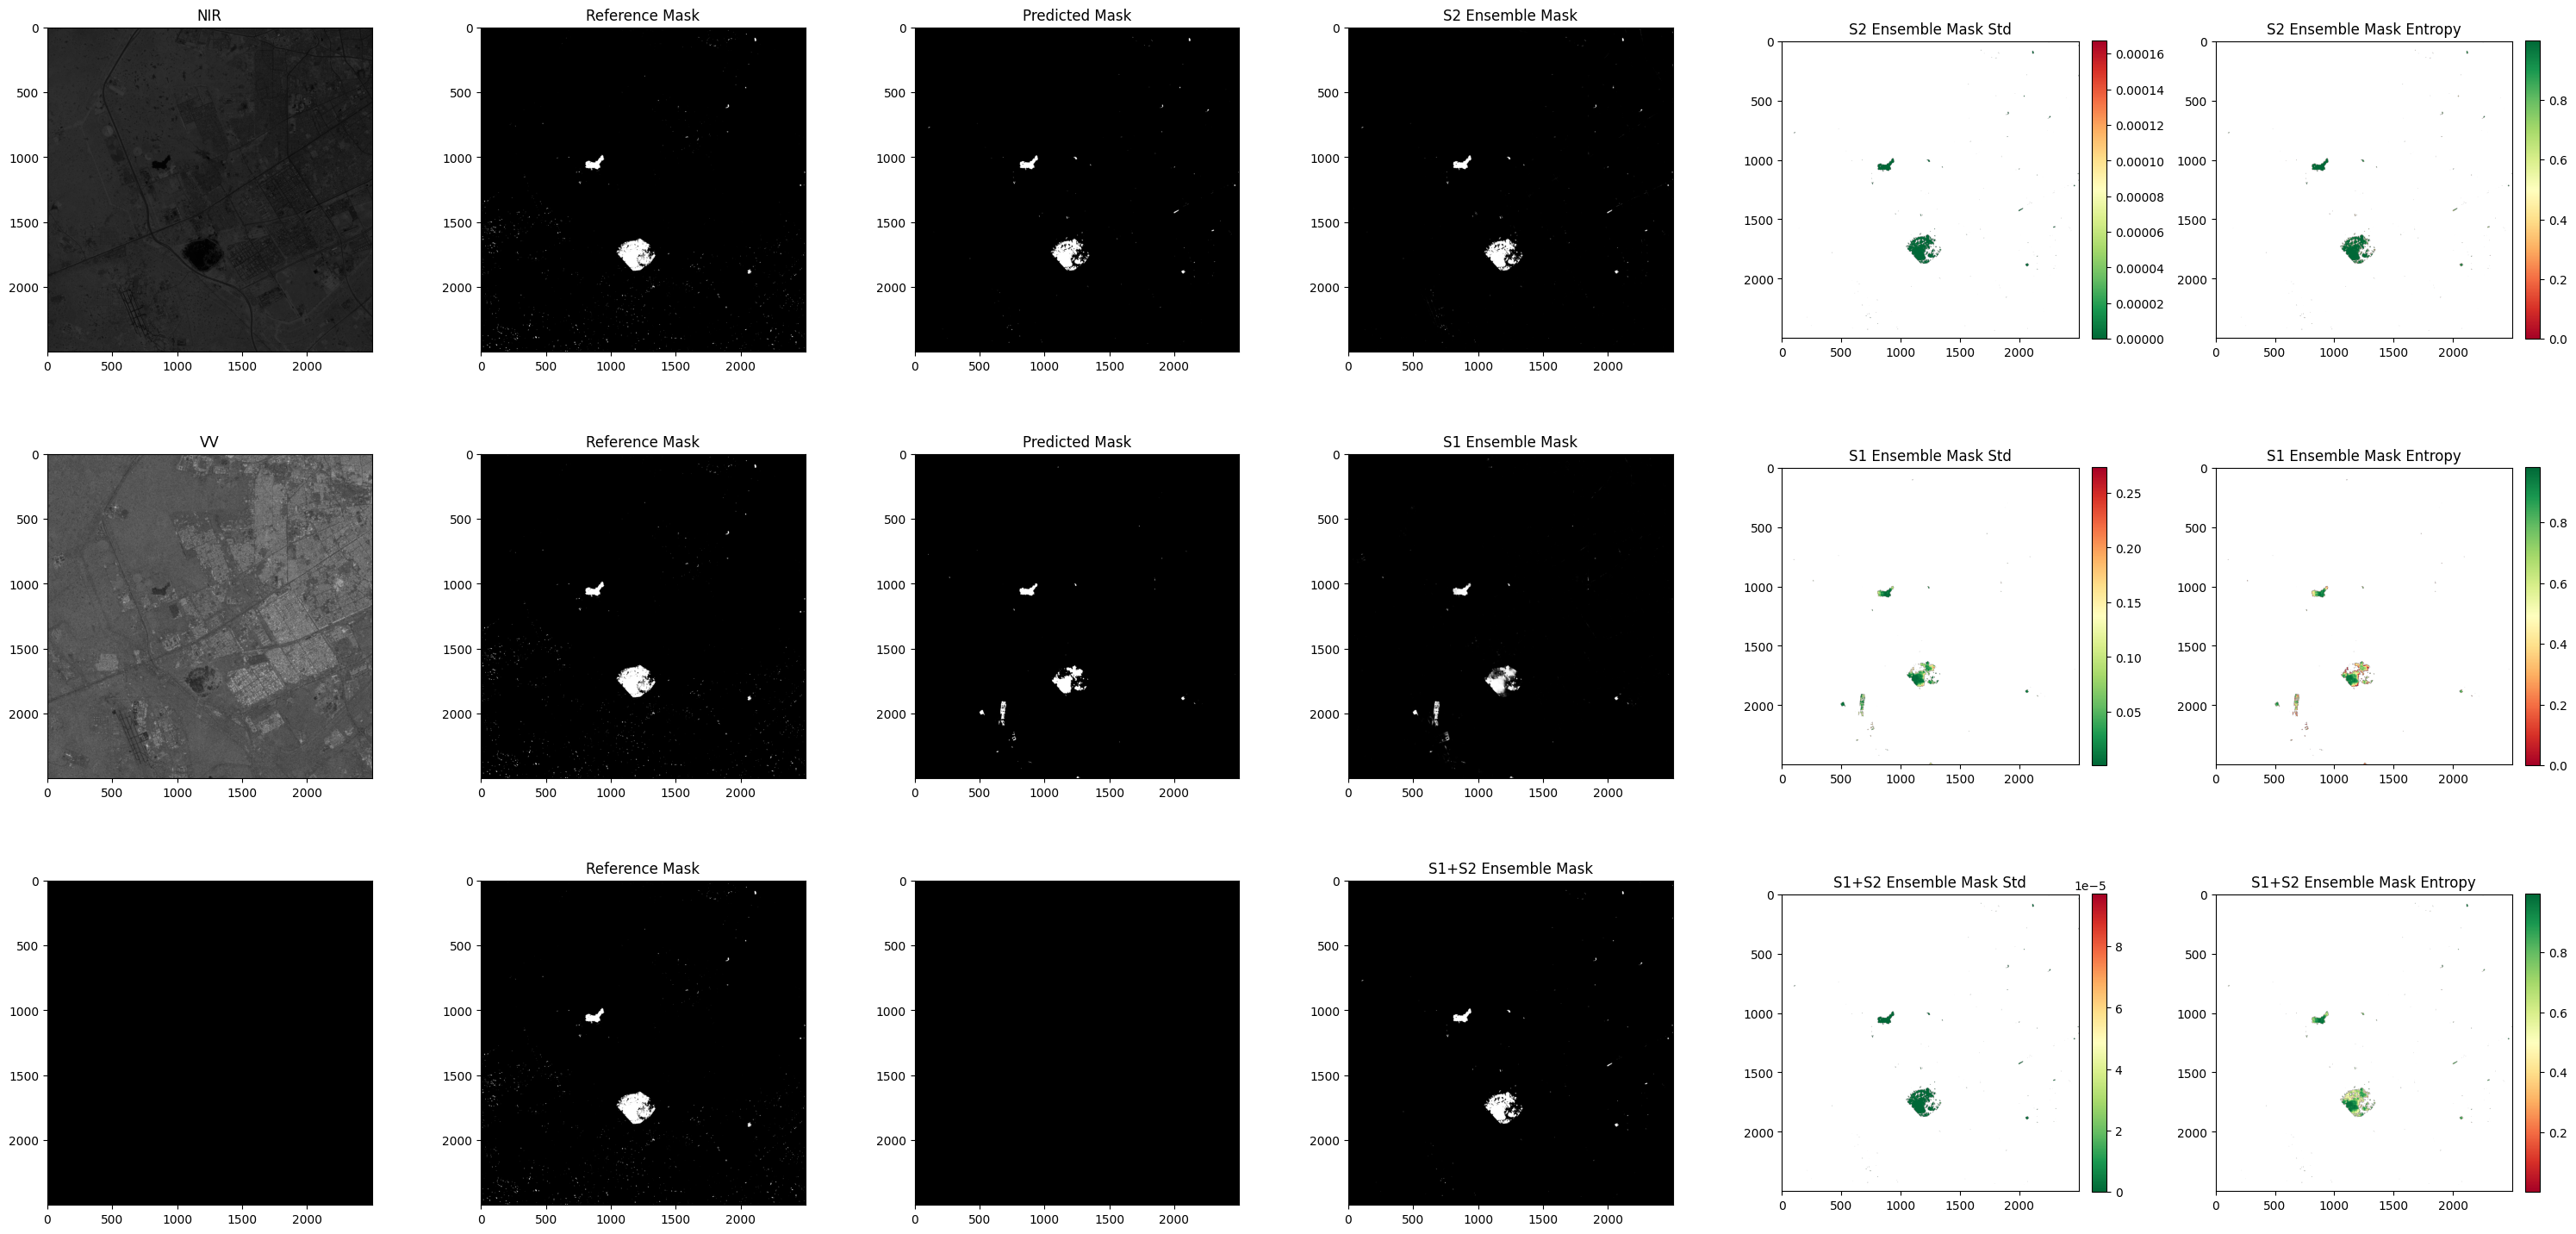

Window(col_off=5000, row_off=0, width=2500, height=2500)


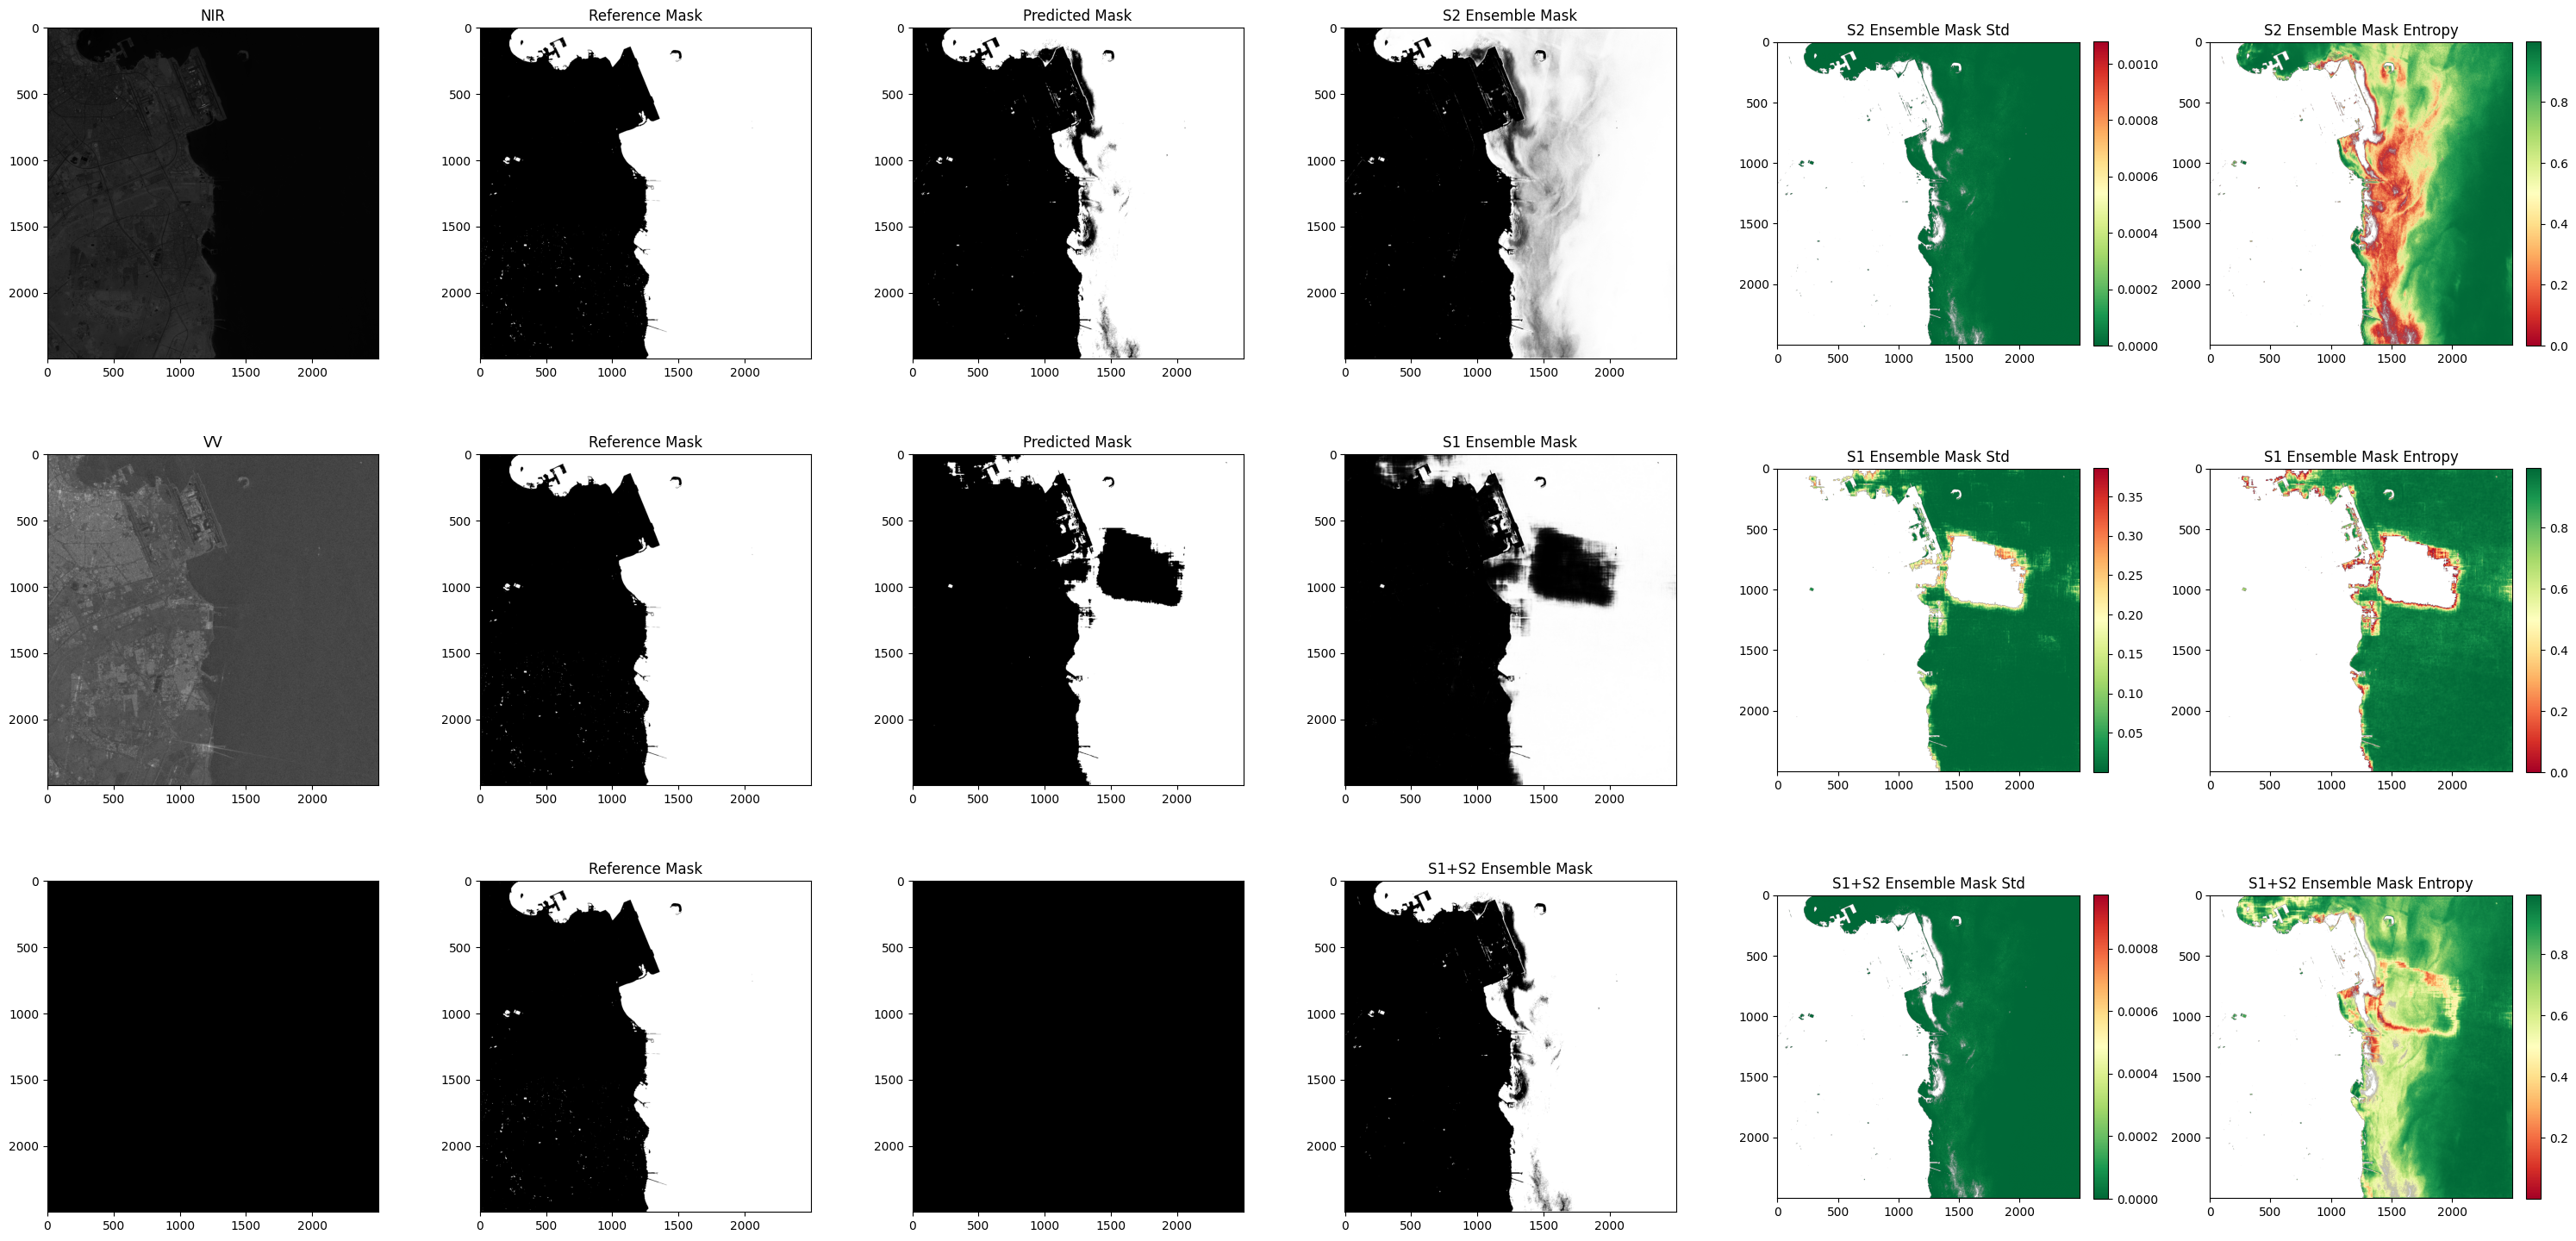

Window(col_off=7500, row_off=0, width=2500, height=2500)


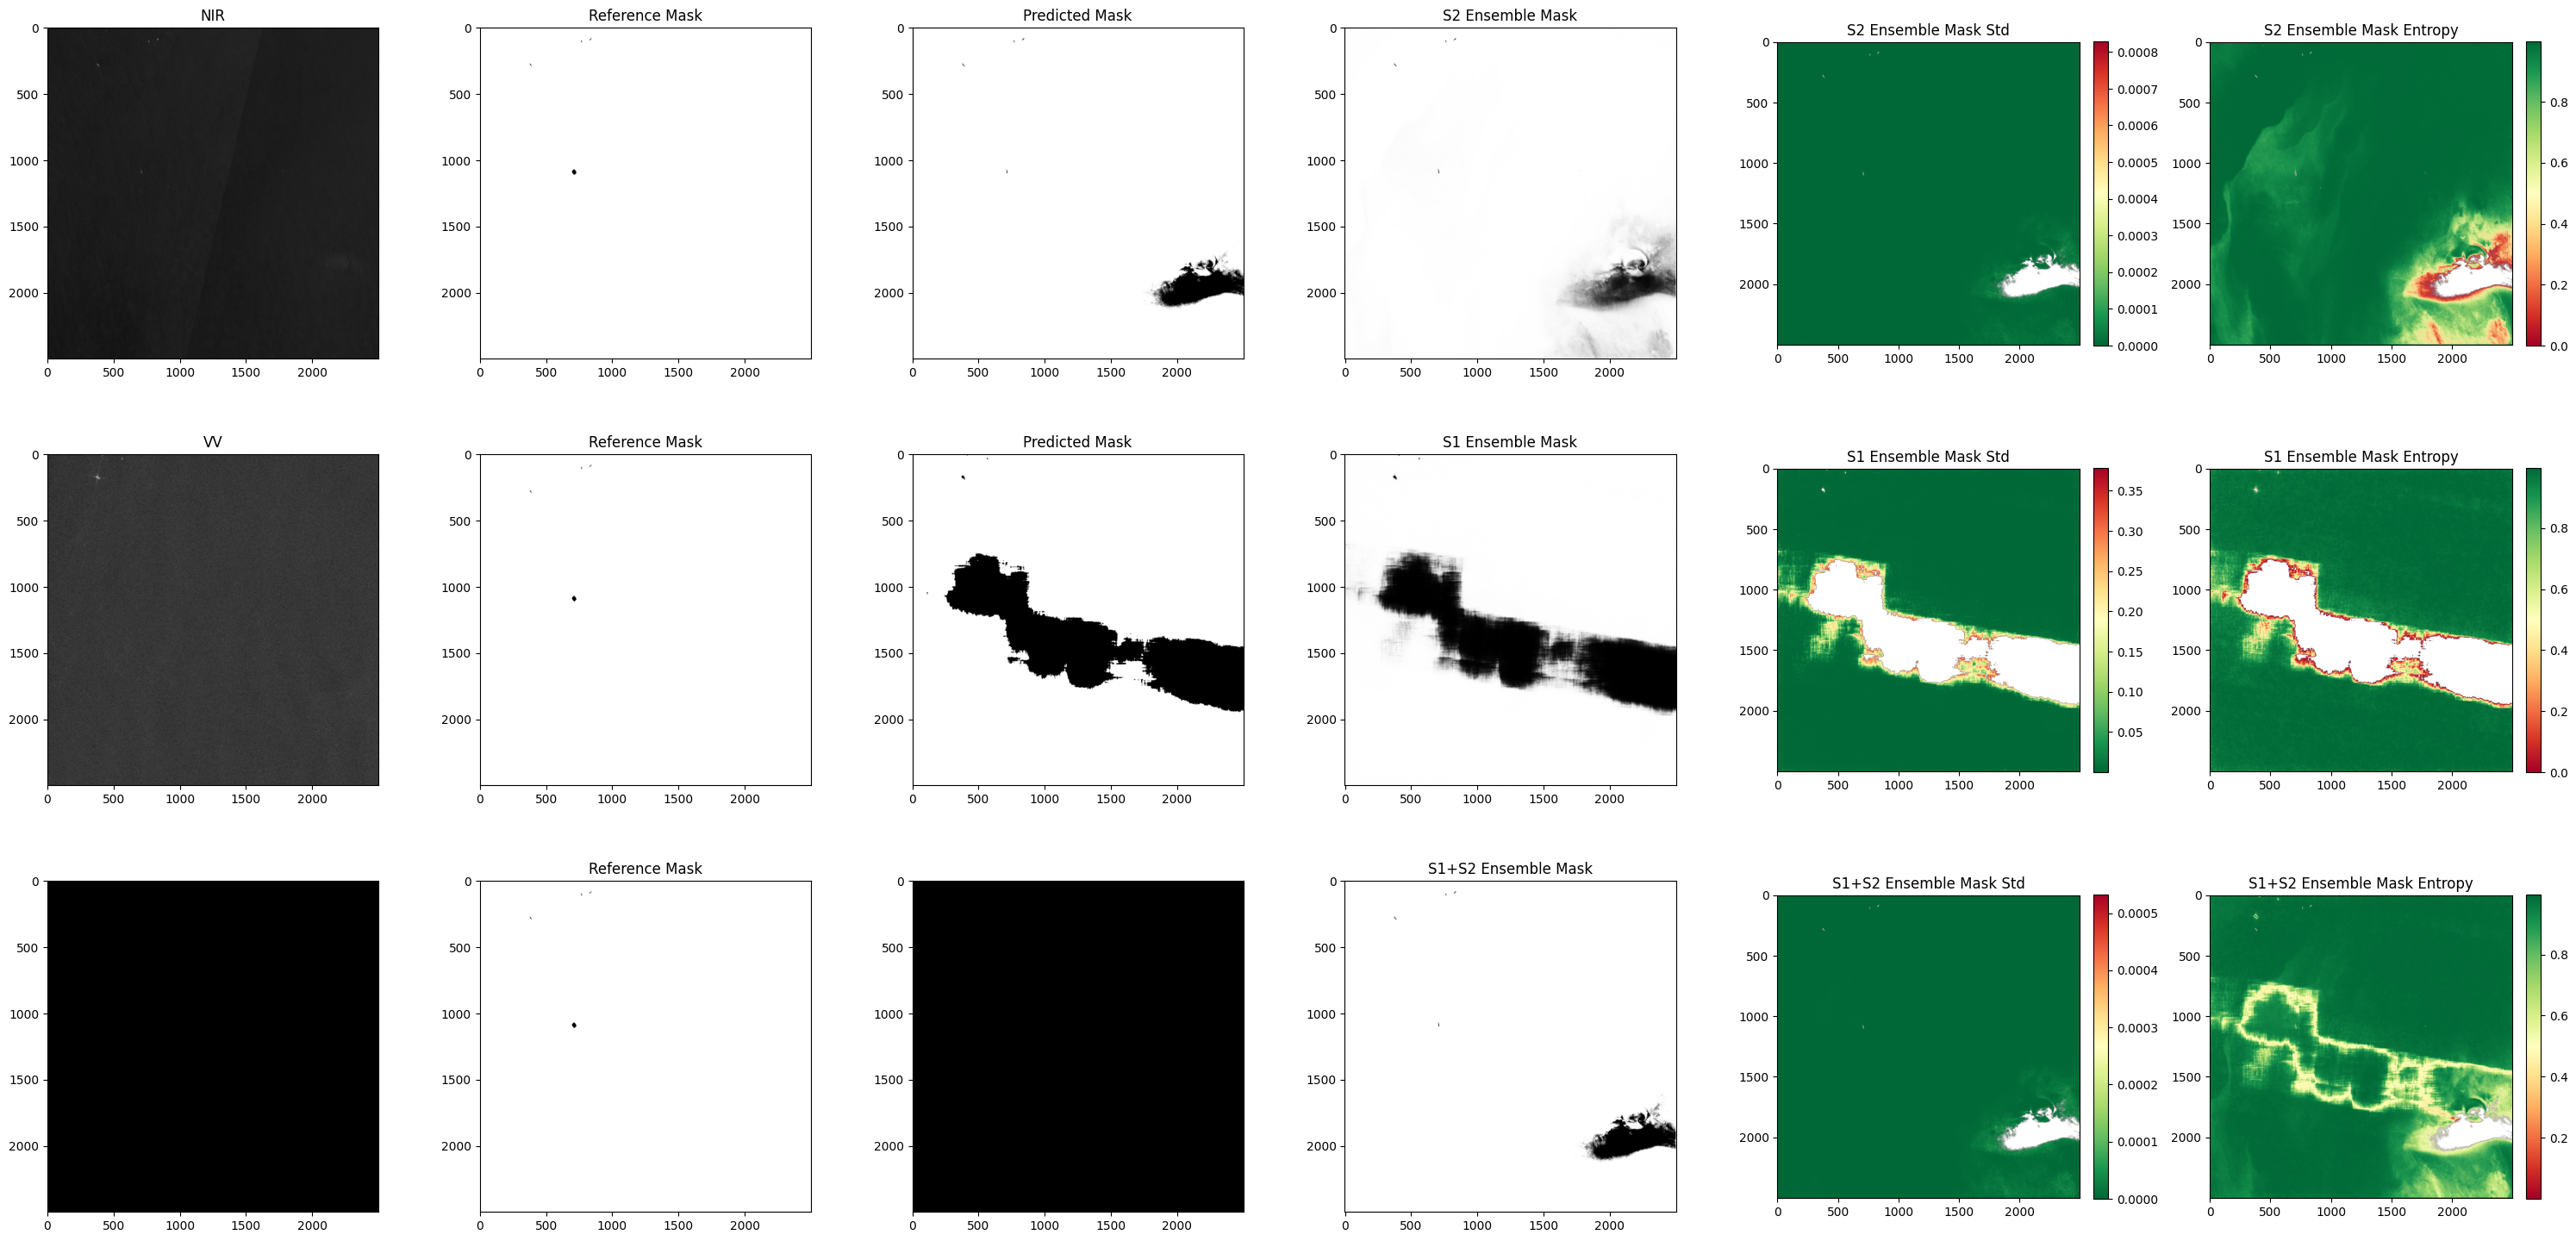

Window(col_off=10000, row_off=0, width=982, height=2500)


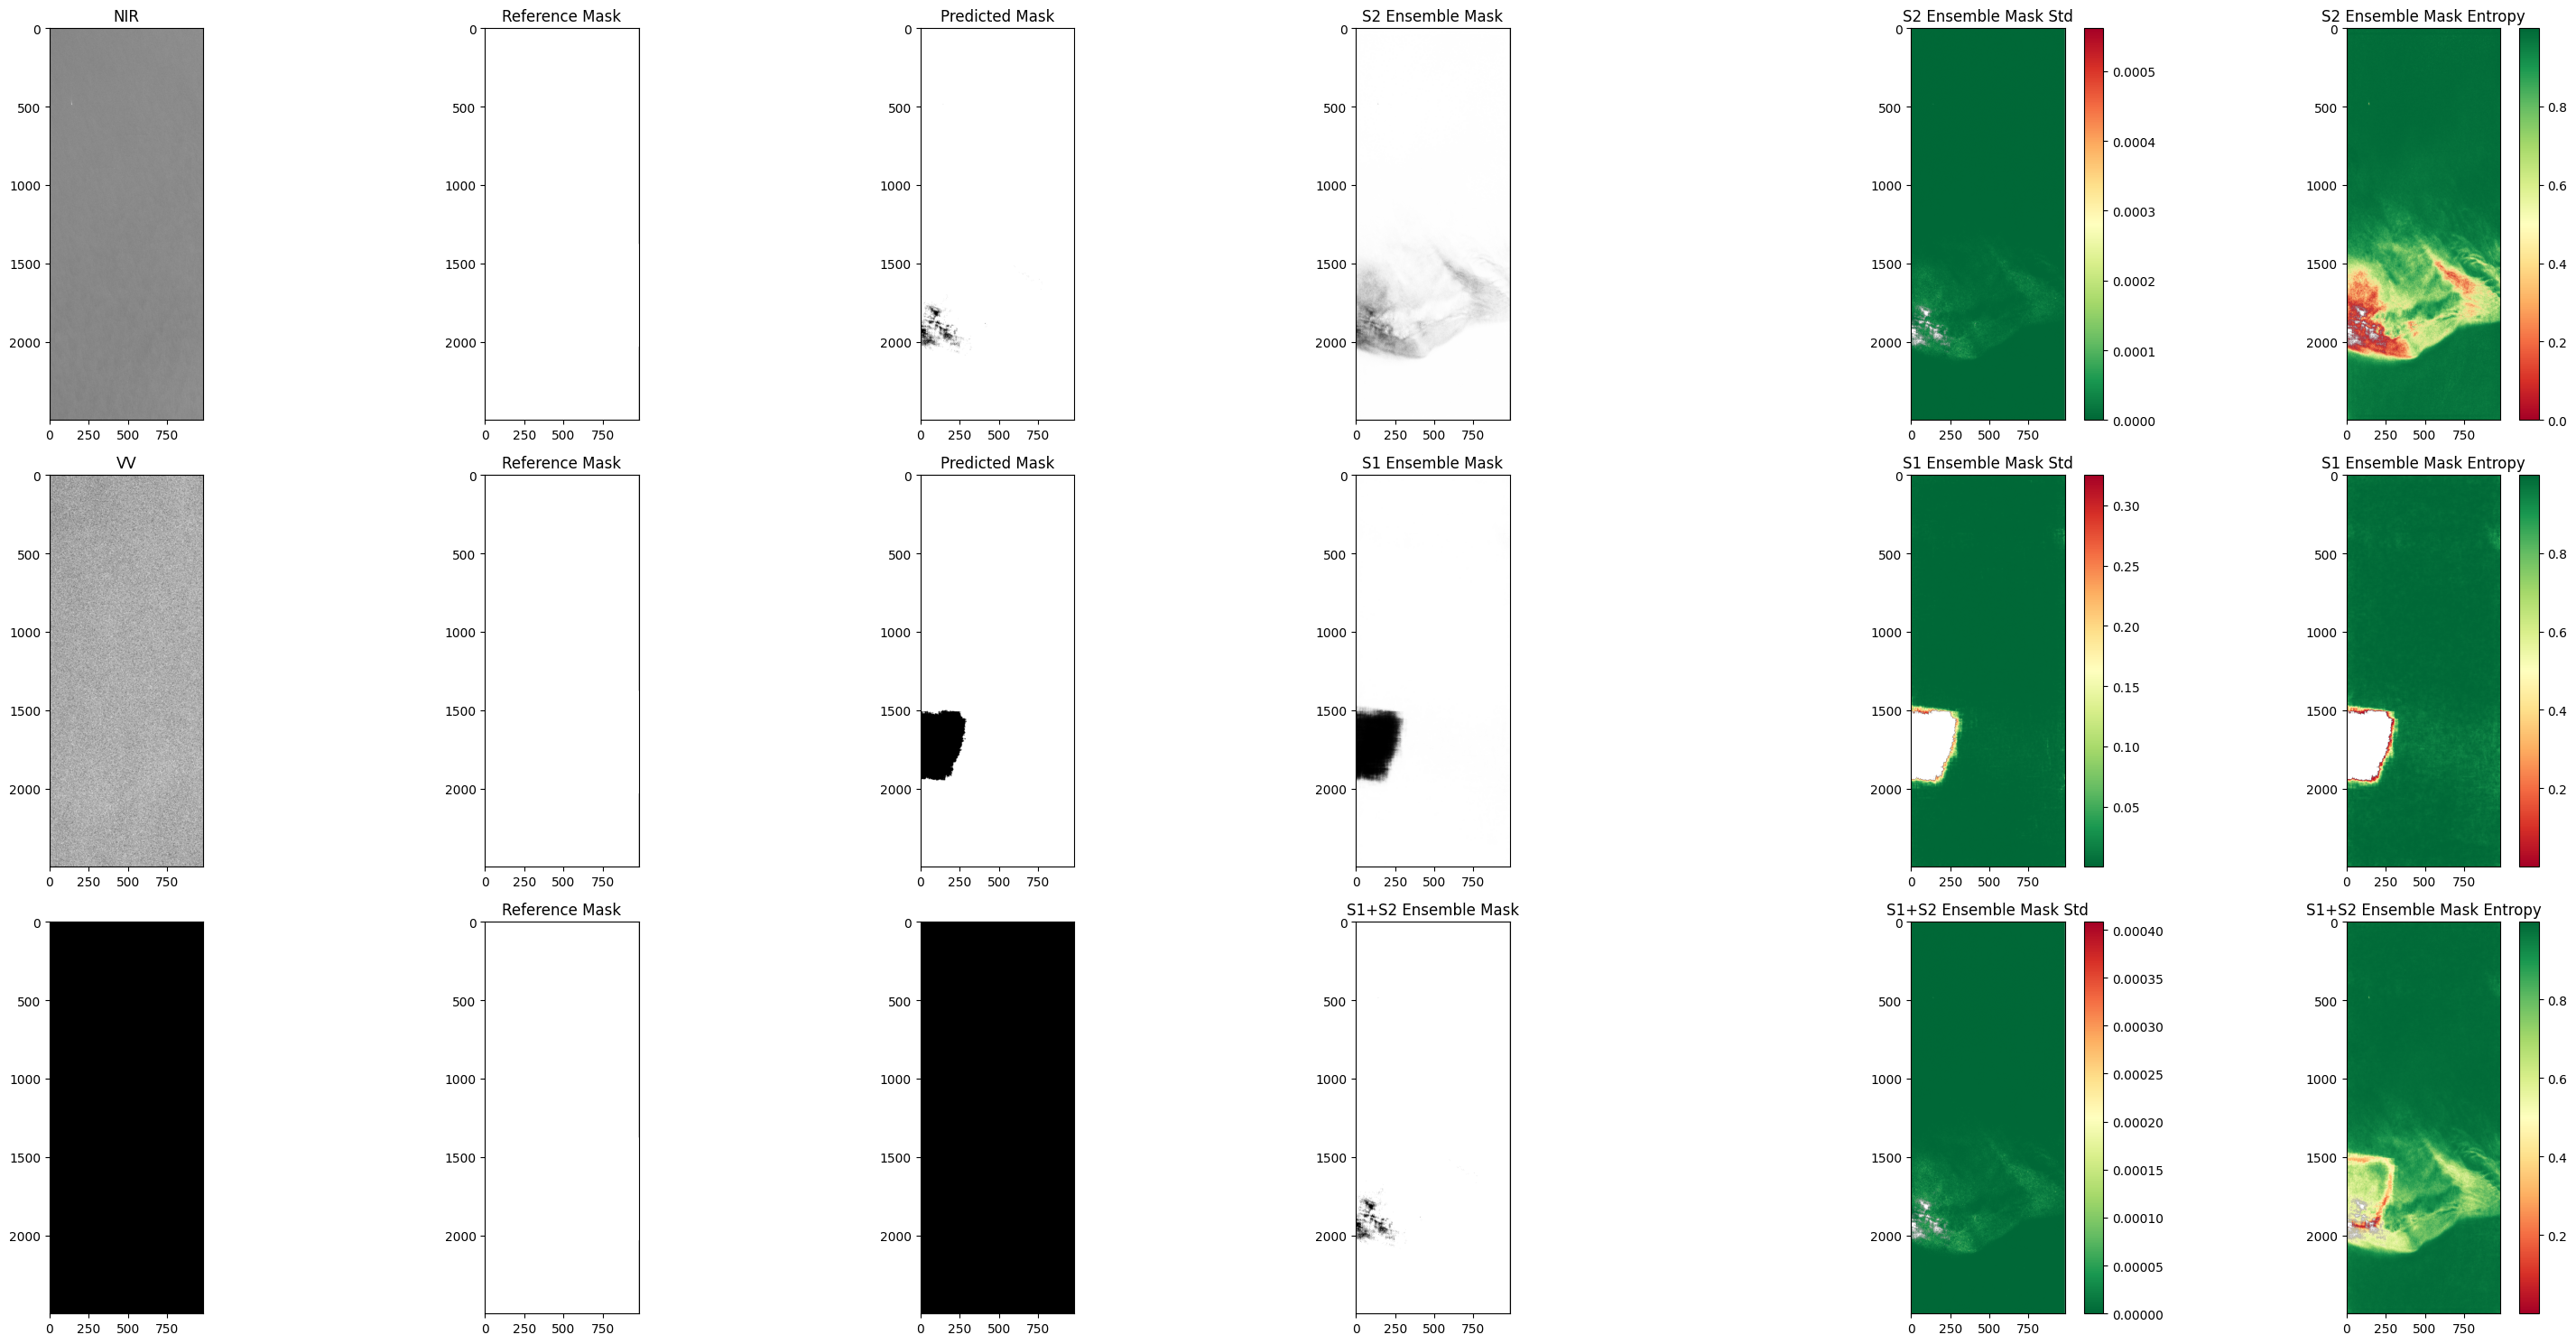

Window(col_off=0, row_off=2500, width=2500, height=2500)


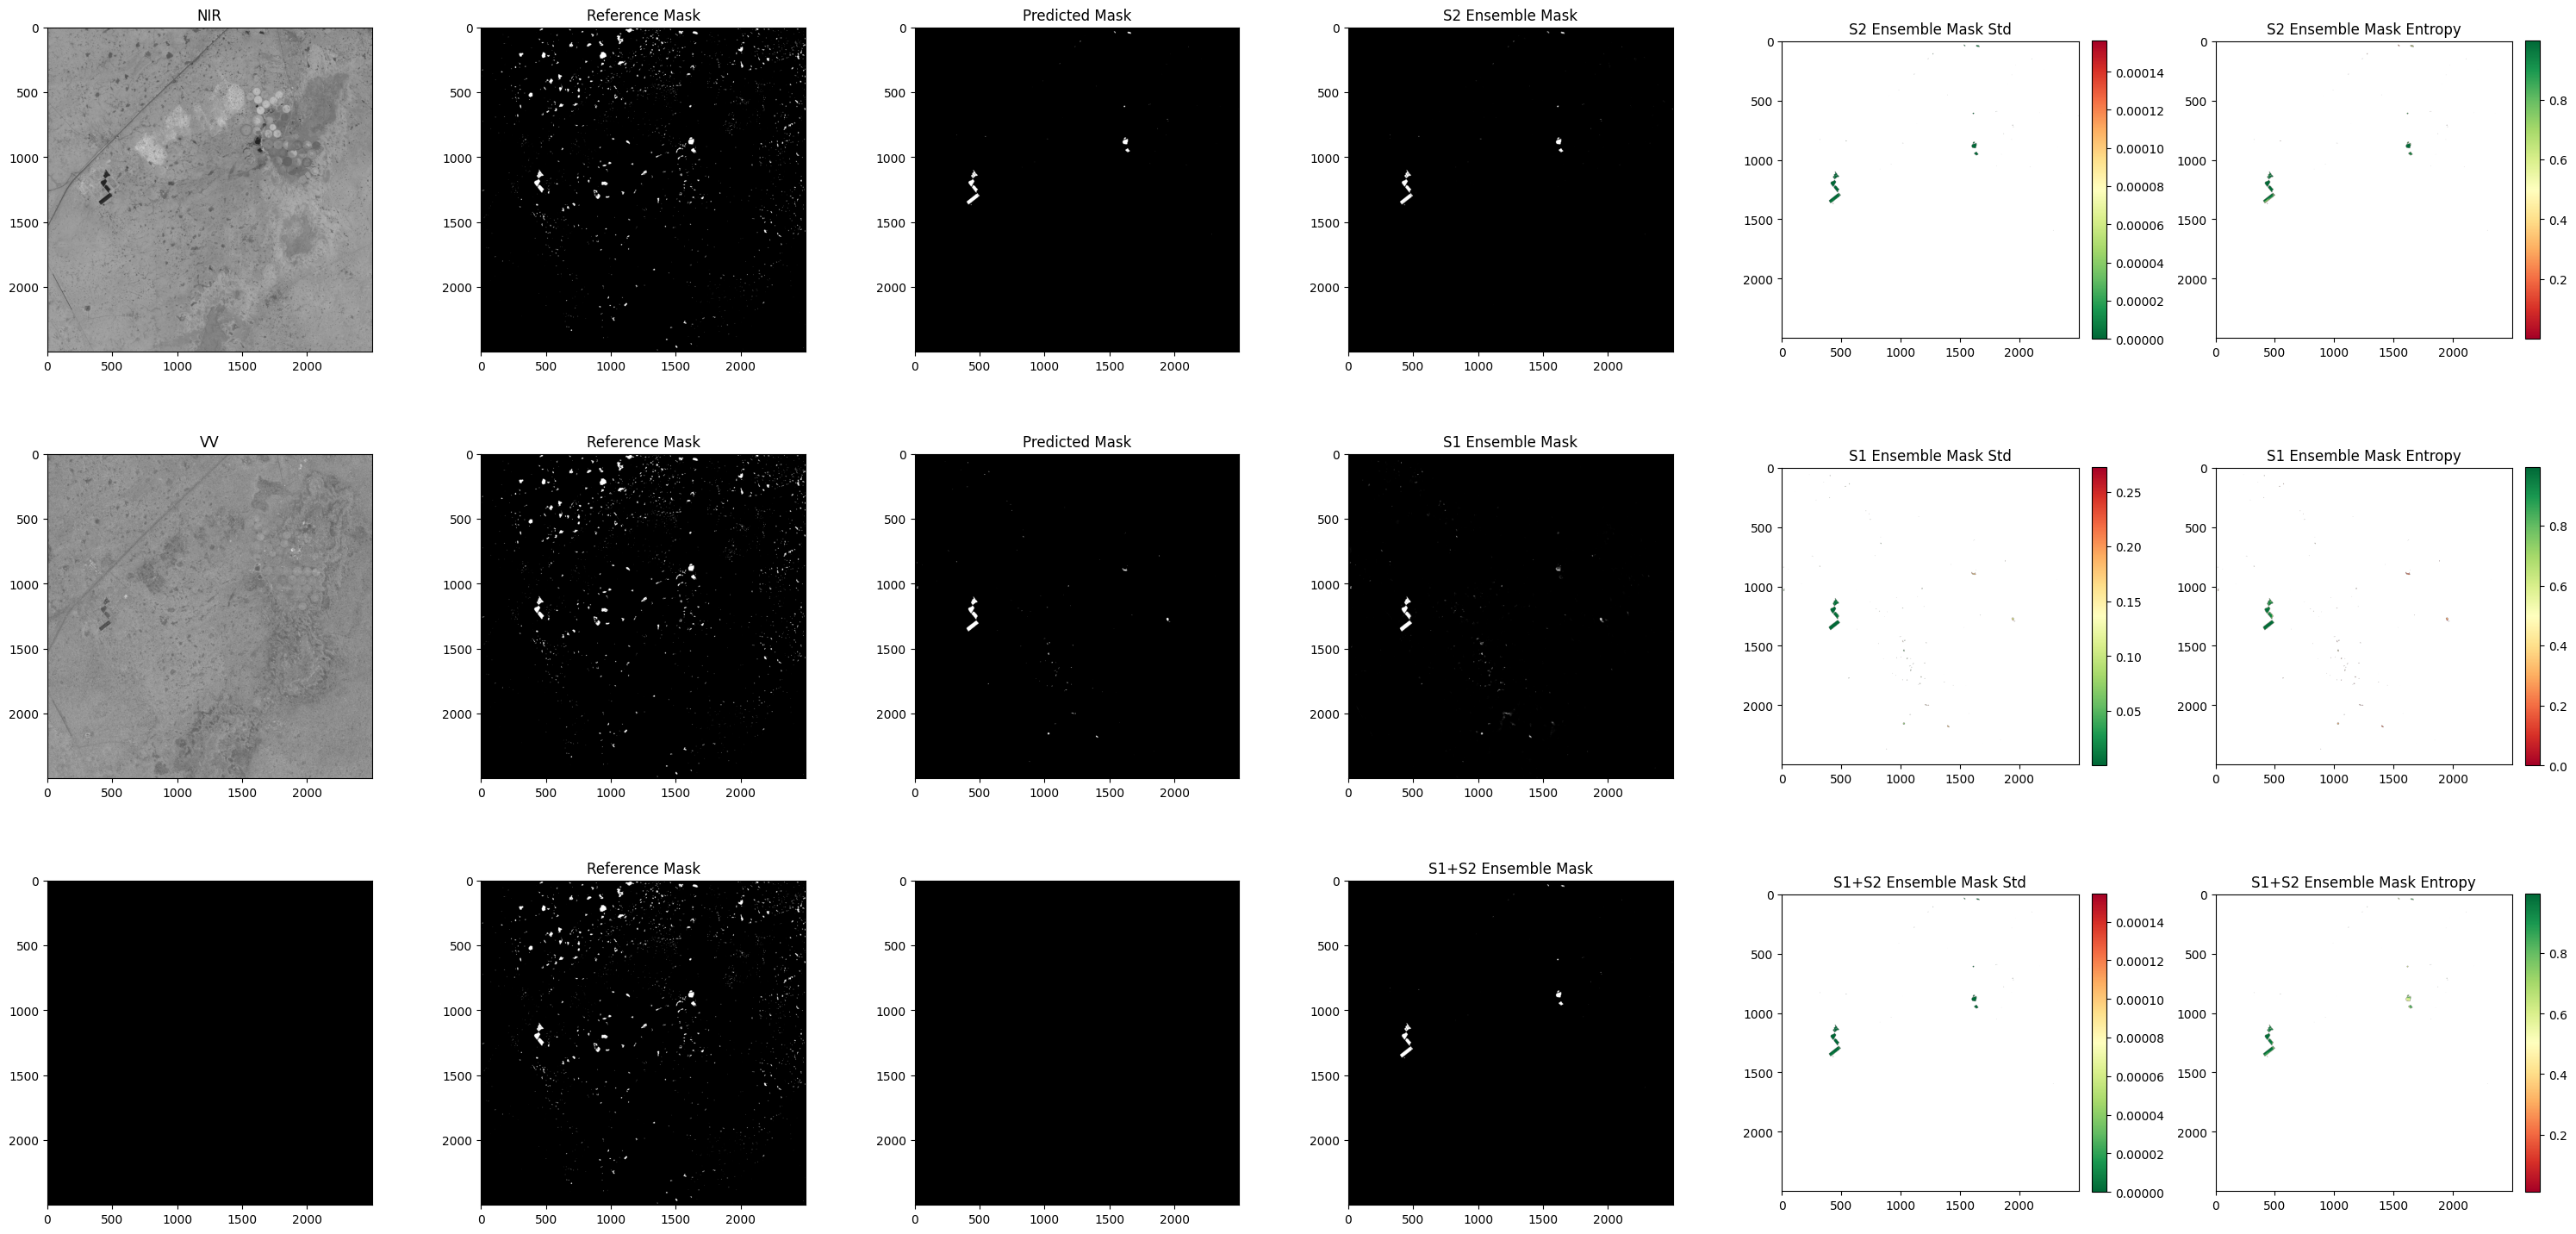

In [ ]:
def predictive_entropy_log2_reversed(mu, eps=1e-8):
    """Compute binary entropy in [0,1], reversed (1=confident, 0=uncertain)."""
    if isinstance(mu, np.ndarray):
        mu = torch.from_numpy(mu)
    H = -(mu * torch.log2(mu + eps) + (1 - mu) * torch.log2(1 - mu + eps))
    H = torch.clamp(H, 0.0, 1.0)
    return (1.0 - H).numpy()  # convert back to numpy

for num, (data_arrays, profiles, window) in enumerate(get_random_subset_from_loaded(loaded, window_size=(2500, 2500))):

    s1, s2, mask, slope = data_arrays
    s1_profile, s2_profile, mask_profile, slope_profile = profiles

    # Prepare images
    s2_trans = np.transpose(s2, (1, 2, 0))
    s1_trans = np.transpose(s1, (1, 2, 0))
    mask = np.transpose(mask, (1, 2, 0))
    slope = np.transpose(slope, (1, 2, 0))
    s1_img = np.concatenate((s1_trans, slope), axis=2)
    s2_img = np.concatenate((s2_trans, slope), axis=2)

    # Predictions
    s2_det, s2_mu, s2_sigma, s1_det, s1_mu, s1_sigma = predict(
        s2_img, s1_img, num_forward=100
    )

    # Ensemble fusion
    mu = (s2_sigma * s1_mu + s1_sigma * s2_mu) / (s2_sigma + s1_sigma + 1e-8)
    sigma = (s2_sigma * s1_sigma) / (s2_sigma + s1_sigma + 1e-8)

    # Entropy calculations
    s1_entropy = predictive_entropy_log2_reversed(s1_mu)
    s2_entropy = predictive_entropy_log2_reversed(s2_mu)
    mu_entropy = predictive_entropy_log2_reversed(mu)
    mu_entropy = (s1_entropy + s2_entropy) / 2

    fig, ax = plt.subplots(3, 6, figsize=(30, 15))  # now 6 columns

    # --- Sentinel-2 ---
    ax[0, 0].imshow(s2_img[:, :, 3], cmap="gray")
    ax[0, 0].set_title("NIR")
    ax[0, 1].imshow(mask, cmap="gray")
    ax[0, 1].set_title("Reference Mask")
    ax[0, 2].imshow(s2_det, cmap="gray")
    ax[0, 2].set_title("Predicted Mask")

    s2_mu_binary = (s2_mu >= 0.5)
    ax[0, 3].imshow(s2_mu, cmap="gray")
    ax[0, 3].set_title("S2 Ensemble Mask")

    s2_sigma_clean = s2_sigma.copy()
    s2_sigma_clean[s2_mu_binary != 1] = np.nan
    s2_sigma_plot = ax[0, 4].imshow(s2_sigma_clean, cmap="RdYlGn_r")
    ax[0, 4].set_title("S2 Ensemble Mask Std")
    fig.colorbar(s2_sigma_plot, ax=ax[0, 4], fraction=0.046, pad=0.04)

    s2_entropy_clean = s2_entropy.copy()
    s2_entropy_clean[s2_mu_binary != 1] = np.nan
    s2_entropy_plot = ax[0, 5].imshow(s2_entropy_clean, cmap="RdYlGn")
    ax[0, 5].set_title("S2 Ensemble Mask Entropy")
    fig.colorbar(s2_entropy_plot, ax=ax[0, 5], fraction=0.046, pad=0.04)

    # --- Sentinel-1 ---
    ax[1, 0].imshow(s1_img[:, :, 0], cmap="gray")
    ax[1, 0].set_title("VV")
    ax[1, 1].imshow(mask, cmap="gray")
    ax[1, 1].set_title("Reference Mask")
    ax[1, 2].imshow(s1_det, cmap="gray")
    ax[1, 2].set_title("Predicted Mask")

    s1_mu_binary = (s1_mu >= 0.5)
    ax[1, 3].imshow(s1_mu, cmap="gray")
    ax[1, 3].set_title("S1 Ensemble Mask")

    s1_sigma_clean = s1_sigma.copy()
    s1_sigma_clean[s1_mu_binary != 1] = np.nan
    s1_sigma_plot = ax[1, 4].imshow(s1_sigma_clean, cmap="RdYlGn_r")
    ax[1, 4].set_title("S1 Ensemble Mask Std")
    fig.colorbar(s1_sigma_plot, ax=ax[1, 4], fraction=0.046, pad=0.04)

    s1_entropy_clean = s1_entropy.copy()
    s1_entropy_clean[s1_mu_binary != 1] = np.nan
    s1_entropy_plot = ax[1, 5].imshow(s1_entropy_clean, cmap="RdYlGn")
    ax[1, 5].set_title("S1 Ensemble Mask Entropy")
    fig.colorbar(s1_entropy_plot, ax=ax[1, 5], fraction=0.046, pad=0.04)

    # --- Ensemble ---
    h, w = s2_img.shape[:2]
    empty_img = np.full((h, w), 255, dtype=np.uint8)
    ax[2, 0].imshow(empty_img, cmap="gray")
    ax[2, 1].imshow(mask, cmap="gray")
    ax[2, 1].set_title("Reference Mask")
    ax[2, 2].imshow(empty_img, cmap="gray")

    mu_binary = mu > 0.5
    ax[2, 3].imshow(mu_binary, cmap="gray")
    ax[2, 3].set_title("S1+S2 Ensemble Mask")

    sigma_clean = sigma.copy()
    sigma_clean[mu_binary != 1] = np.nan
    sigma_plot = ax[2, 4].imshow(sigma_clean, cmap="RdYlGn_r")
    ax[2, 4].set_title("S1+S2 Ensemble Mask Std")
    fig.colorbar(sigma_plot, ax=ax[2, 4], fraction=0.046, pad=0.04)

    mu_entropy_clean = mu_entropy.copy()
    mu_entropy_clean[mu_binary != 1] = np.nan
    mu_entropy_plot = ax[2, 5].imshow(mu_entropy_clean, cmap="RdYlGn")
    ax[2, 5].set_title("S1+S2 Ensemble Mask Entropy")
    fig.colorbar(mu_entropy_plot, ax=ax[2, 5], fraction=0.046, pad=0.04)

    plt.tight_layout()
    print(window)
    plt.show()

    # # --- Save all arrays including entropy ---
    # base_path = Path("/eodc/private/tuwgeo/users/mabdelaa/watmap_test_cases_entropy")
    # base_path.mkdir(parents=True, exist_ok=True)
    # test_case_dir = base_path / f"{num}"
    # image_id = f"{num}_{window.col_off}_{window.row_off}"
    # test_case_dir.mkdir(parents=True, exist_ok=True)

    # data_arrays = [
    #     s1_det, s1_mu, s1_sigma, s1_entropy,
    #     s2_det, s2_mu, s2_sigma, s2_entropy,
    #     mu, sigma, mu_entropy, mask
    # ]
    # data_arrays = [np.expand_dims(arr, axis=-1) if arr.ndim < 3 else arr for arr in data_arrays]
    # data_arrays = [np.transpose(arr, (2, 0, 1)) for arr in data_arrays]
    # data_arrays_label = [
    #     "s1_det", "s1_mu", "s1_sigma", "s1_entropy",
    #     "s2_det", "s2_mu", "s2_sigma", "s2_entropy",
    #     "mu", "sigma", "mu_entropy", "mask"
    # ]

    # for data, label in zip(data_arrays, data_arrays_label):
    #     save_path = test_case_dir / label
    #     save_path.mkdir(parents=True, exist_ok=True)
    #     img_path = test_case_dir / label / f"{label}_{image_id}.tif"
    #     count = data.shape[0]
    #     s2_profile.update({"count": count, "dtype": "float32"})
    #     with rio.open(img_path, "w", **s2_profile) as dst:
    #         dst.write(data)
    #         print(f"Saved {label} to {img_path}")

   

print("Processing Completed.........")
